# An introduction to Physical Informed Neural Networks (PINNs)

In [1]:
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm

**Table of contents**

1. Creation of a neural network


### 1. Creation of a neural network

Here, we create a neural network for regression. 

In [2]:
class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out


In [3]:
# Define dataset
x_train = torch.tensor([[0.0000]], dtype=torch.float32)
y_train = torch.tensor([[1.0000]], dtype=torch.float32)

In [4]:
# Initialize the model
model = simple_NN()

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(1000):

    # Compute prediction error
    pred = model(x_train)
    loss = loss_fn(pred, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 100 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

/home/ggarnier/anaconda3/envs/inverse-neural-galerkin/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 0, loss: 1.445376
epoch: 100, loss: 0.000006
epoch: 200, loss: 0.000000
epoch: 300, loss: 0.000000
epoch: 400, loss: 0.000000
epoch: 500, loss: 0.000000
epoch: 600, loss: 0.000000
epoch: 700, loss: 0.000000
epoch: 800, loss: 0.000000
epoch: 900, loss: 0.000000


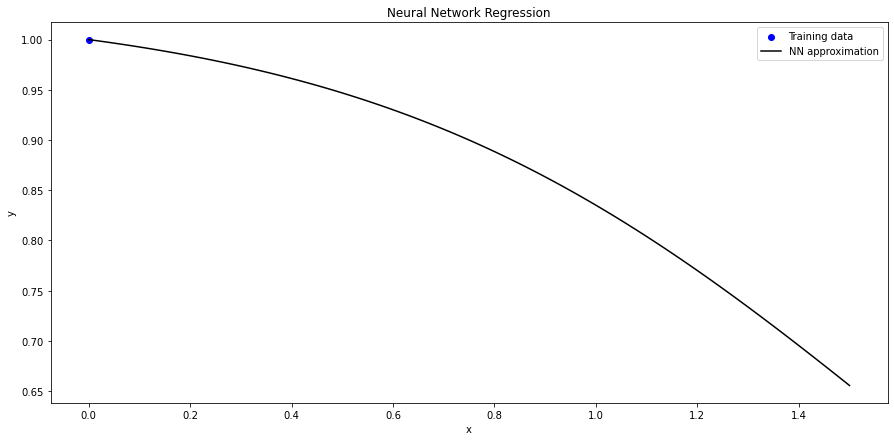

In [5]:
# evaluate the model on all data points in the domain
domain = [0.0, 1.5]
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = model(x_eval)

# plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Training data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.set(title="Neural Network Regression", xlabel="x", ylabel="y")
ax.legend()

## 2. Severals models

### 2.1 The logistic equation

Consider the equation
$$\frac{dN}{dt} = r \cdot N(1-N) $$
where $$ N(0) = n_0 $$

Here, we compute $\frac{dN}{dt}$ with the automatic differentiation

In [6]:
# We compute dN with automatic differentiation

def df(f: simple_NN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value 


Here is the ODE parameters

In [7]:
R = 1.0
ft0 = 1.0

# Generate 10 evenly distributed collocation points
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

We add the loss with dynamics, boundaries condition and loss of data.
$$ \mathcal{L}_{tot} = \mathcal{L}_{data} + \mathcal{L}_{dyn} + \mathcal{L}_{boundary}$$

In [8]:
# Wrap everything into a function
def compute_loss(nn: simple_NN, 
                 t: torch.Tensor = None, 
                 x: torch.Tensor = None,
                 y: torch.Tensor = None,
                 ) -> torch.float:
    """Compute the full loss function as pde loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    pde_loss = df(nn, t) - R * t * (1 - t)
    pde_loss = pde_loss.pow(2).mean()

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    bc_loss = nn(boundary) - ft0
    bc_loss = bc_loss.pow(2)
    
    mse_loss = torch.nn.MSELoss()(nn(x), y)
    
    tot_loss = pde_loss + bc_loss + mse_loss
    
    return tot_loss

We optimize the code

In [9]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Train
for ep in range(2000):

    loss = compute_loss(model, t, x_train, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 500 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 2.820978
epoch: 500, loss: 0.000074
epoch: 1000, loss: 0.000004
epoch: 1500, loss: 0.000001


We compute the usual solution by solving the ODE

In [10]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=x_eval.squeeze().detach().numpy()
)

f_colloc = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=t.squeeze().detach().numpy()
).y.T


We plot the solution

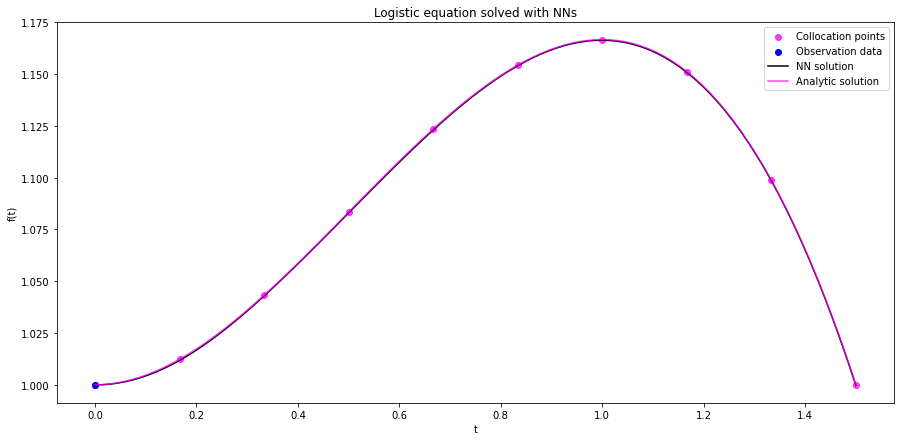

In [11]:
# evaluation on the domain [0, 1.5]
f_eval = model(x_eval)

# plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Observation data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN solution", color="black")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Analytic solution", color="magenta", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()


### 2.2 The Wave equation

We aim to solve the wave equation
$$ \frac{\partial^2 u}{\partial x^2} -\frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} = 0$$ 

We define a Neural network that can be evaluated in space and time

In [12]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out


How to differentiate the neural network

In [13]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

We consider the loss $$ \mathcal{L}_{dyn} = \bigg( \frac{\partial^2 u}{\partial x^2} -\frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} \bigg)^2.$$

Also, we consider a boundary condition by 
* imposing periodic boundary conditions at the domain extrema : $f(x_0, t) = 0$ and $f(x_1, t)=0$
  $$ \mathcal{L}_{BC} = f(x_0, t)^2 + f(x_1, t)^2$$
* imposing an initial condition on $f(t_0,x) = \frac{1}{2} \sin(2\pi x)$
  $$ \mathcal{L}_{initF} = \left( f(x, t_0) - \frac{1}{2} \sin(2\pi x) \right)^2 $$
* imposing an initial condition on $\frac{\partial f}{\partial t}\big|_{t=0} = 0$
  $$ \mathcal{L}_{initDF} = \left( \frac{\partial f}{\partial t} \bigg\rvert_{t=0} \right)^2$$

The total loss is 
$$ \boxed{\mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{initF} + \mathcal{L}_{initDF}} $$

In [14]:
def initial_condition(x) -> torch.Tensor:
    res = torch.sin( 2*np.pi * x).reshape(-1, 1) * 0.5
    return res

def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None, 
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None, 
    t_idx: torch.Tensor = None,  
    C: float = 1.0,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdx(model, x, t, order=2) - (1/C**2) * dfdt(model, x, t, order=2)

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]      
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]    
    boundary_loss_x1 = model(boundary_x1, t_idx)                                    # f(x1, t)
    
    # initial conditions
    f_initial = initial_condition(x_idx)                         # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_idx)                          # t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_idx, t_initial) - f_initial         # L_initF
    initial_loss_df = dfdt(model, x_idx, t_initial, order=1)     # L_initDF
    
    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        initial_loss_df.pow(2).mean()

    return final_loss

Step of optimization

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(3000):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.182975
epoch: 300, loss: 0.038237
epoch: 600, loss: 0.029307
epoch: 900, loss: 0.056336
epoch: 1200, loss: 0.022931
epoch: 1500, loss: 0.022087
epoch: 1800, loss: 0.016261
epoch: 2100, loss: 0.015323
epoch: 2400, loss: 0.013808
epoch: 2700, loss: 0.018089


Visualisation

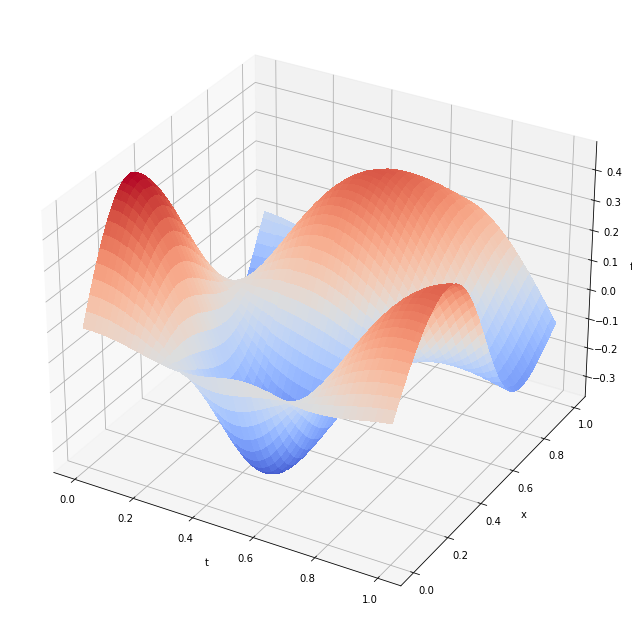

In [16]:
# Prediction
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig=plt.figure(figsize=(25,25))
ax = fig.add_subplot(211,projection='3d')
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show()

### 2.3 The Heat Equation

We aim to solve the wave equation
$$ \frac{\partial u}{\partial t} - \lambda \frac{\partial^2 u}{\partial x^2} = 0$$ 

We consider the loss $$ \mathcal{L}_{dyn} = \bigg( \frac{\partial u}{\partial t} - \lambda \frac{\partial^2 u}{\partial x^2} \bigg)^2.$$

Also, we consider a boundary condition by 
* imposing periodic boundary conditions at the domain extrema : $f(x_0, t) = 0$ and $f(x_1, t)=0$
  $$ \mathcal{L}_{BC} = f(x_0, t)^2 + f(x_1, t)^2$$
* imposing an initial condition on $f(t_0,x) = \frac{1}{2} \sin^2(2\pi x)$
  $$ \mathcal{L}_{initF} = \left( f(x, t_0) - \frac{1}{2} \sin^2(2\pi x) \right)^2 $$

The total loss is 
$$ \boxed{\mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{initF}}$$

In [17]:
def initial_condition(x) -> torch.Tensor:
    res = 0.5*(torch.sin( 2*np.pi * x).reshape(-1, 1))**2
    return res

def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None, 
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None, 
    t_idx: torch.Tensor = None,  
    lamb: float = 1.0,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = lamb * dfdx(model, x, t, order=2) - dfdt(model, x, t, order=1)

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]      
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]    
    boundary_loss_x1 = model(boundary_x1, t_idx)                                    # f(x1, t)
    
    # initial conditions
    f_initial = initial_condition(x_idx)                         # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_idx)                          # t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_idx, t_initial) - f_initial         # L_initF
    
    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        initial_loss_f.pow(2).mean()

    return final_loss

optimization

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(3000):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.181336
epoch: 300, loss: 0.031758
epoch: 600, loss: 0.030955
epoch: 900, loss: 0.030251
epoch: 1200, loss: 0.029919
epoch: 1500, loss: 0.029843
epoch: 1800, loss: 0.028325
epoch: 2100, loss: 0.027194
epoch: 2400, loss: 0.026229
epoch: 2700, loss: 0.016913


visualisation

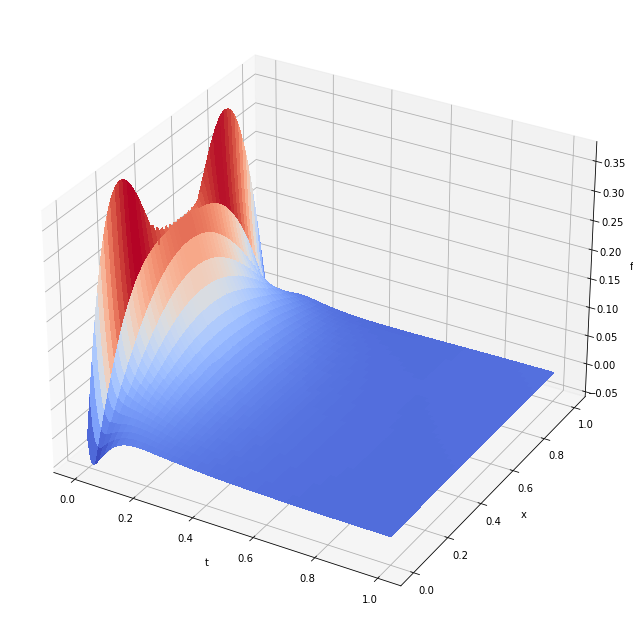

In [19]:
# Prediction
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig=plt.figure(figsize=(25,25))
ax = fig.add_subplot(211,projection='3d')
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show()

### 2.4 The Equation of Cahn Hilliard

In [20]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

def dfdxhilliard(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    f_value = 2* f_value + 4 *  f_value**3 - 6 *  f_value**2
    return df(f_value, x, order=order)

We aim to simulate the equation
$$ \partial_t u = \partial_{xx}\mu, \mu = -\partial_{xx} u + f’(u), f(u) = u^2*(1-u)^2 $$ 

ie
$$ \partial_t u = -\partial_{xxxx}u + \partial_{xx}(2u + 4u^3 - 6u^2)$$ 

We consider the loss $$ \mathcal{L}_{dyn} = \big( \partial_t u +\partial_{xxxx}u - \partial_{xx}(2u + 4u^3 - 6u^2)\big)^2.$$


Also, we consider a boundary condition by 
* * imposing an initial condition on $\frac{\partial f}{\partial t}\big|_{x=0} = 0$ et $\frac{\partial f}{\partial t}\big|_{x=1} = 0$
  $$ \mathcal{L}_{initDF} = \left( \frac{\partial f}{\partial x} \bigg\rvert_{x=0} \right)^2 + \left( \frac{\partial f}{\partial x} \bigg\rvert_{x=1} \right)^2$$

The total loss is 
$$ \boxed{\mathcal{L}_{PDE} + \mathcal{L}_{initDF}}$$

In [21]:
def initial_condition(x) -> torch.Tensor:
    res = 0.5*(torch.sin( 2*np.pi * x).reshape(-1, 1))**2
    return res

def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None, 
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None, 
    t_idx: torch.Tensor = None,  
    lamb: float = 1.0,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdt(model, x, t, order=1) - dfdx(model, x, t, order=2) + dfdxhilliard(model, x, t, order=0)

    
    # initial conditions
    f_initial = initial_condition(x_idx)                         # 0.5*sin(2*pi*x)
    t_initial = torch.zeros_like(x_idx)# t0
    t_initial1 = torch.ones_like(x_idx)# t0
    t_initial.requires_grad = True
    initial_loss_f = model(x_idx, t_initial) - f_initial         # L_initF
    initial_loss_df1 = dfdx(model, x_idx, t_initial, order=1)     # L_initDF
    initial_loss_df2 = dfdx(model, x_idx, t_initial1, order=1)     # L_initDF
    
    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        initial_loss_f.pow(2).mean() + \
        initial_loss_df1.pow(2).mean() + \
        initial_loss_df2.pow(2).mean()

    return final_loss


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(200):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 10 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.061052
epoch: 10, loss: 0.049021


epoch: 20, loss: 0.034052
epoch: 30, loss: 0.032935
epoch: 40, loss: 0.032298
epoch: 50, loss: 0.032074
epoch: 60, loss: 0.031925
epoch: 70, loss: 0.031834
epoch: 80, loss: 0.031757
epoch: 90, loss: 0.031692
epoch: 100, loss: 0.031641
epoch: 110, loss: 0.031605
epoch: 120, loss: 0.031579
epoch: 130, loss: 0.031562
epoch: 140, loss: 0.031551
epoch: 150, loss: 0.031544
epoch: 160, loss: 0.031540
epoch: 170, loss: 0.031537
epoch: 180, loss: 0.031535
epoch: 190, loss: 0.031533


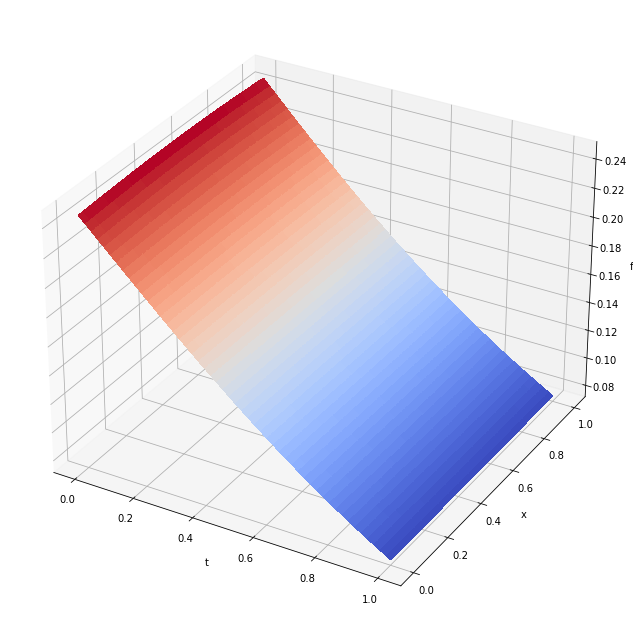

In [23]:
# Prediction
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig=plt.figure(figsize=(25,25))
ax = fig.add_subplot(211,projection='3d')
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show()